In [24]:
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [25]:
path = "results/history_RoBERT-base_finetune_multitask_512_config_0.0001_3e-06_3_700000.json"

In [ ]:
with open(path, "r") as f:
    data = json.load(f)

train_reg_labels = data["train_reg_labels"]
val_reg_labels = data["val_reg_labels"]

train_class_labels = data["train_class_labels"]
val_class_labels = data["val_class_labels"]

val_loss = data["val_loss"]
train_loss = data["train_loss"]

all_train_reg_predictions = data["train_reg_predictions"]
all_val_reg_predictions = data["val_reg_predictions"]

all_train_class_predictions = data["train_class_predictions"]
all_val_class_predictions = data["val_class_predictions"]

train_reg_rmse = [
    np.sqrt(np.mean((np.array(train_reg_labels) - np.array(pred)) ** 2))
    for pred in all_train_reg_predictions
]
val_reg_rmse = [
    np.sqrt(np.mean((np.array(val_reg_labels) - np.array(pred)) ** 2))
    for pred in all_val_reg_predictions
]

train_reg_mae = [
    np.mean(np.abs(np.array(train_reg_labels) - np.array(pred)))
    for pred in all_train_reg_predictions
]
val_reg_mae = [
    np.mean(np.abs(np.array(val_reg_labels) - np.array(pred)))
    for pred in all_val_reg_predictions
]


num_classes = max(train_class_labels) + 1
train_class_bce = []
for epoch_logits in all_train_class_predictions:
    epoch_logits = np.array(epoch_logits)
    y_onehot = np.zeros((len(train_class_labels), num_classes))
    y_onehot[np.arange(len(train_class_labels)), train_class_labels] = 1
    p = 1 / (1 + np.exp(-epoch_logits))
    loss = -(y_onehot * np.log(p + 1e-9) + (1 - y_onehot) * np.log(1 - p + 1e-9))
    train_class_bce.append(np.mean(loss))

val_class_bce = []
for epoch_logits in all_val_class_predictions:
    epoch_logits = np.array(epoch_logits)
    y_onehot = np.zeros((len(val_class_labels), num_classes))
    y_onehot[np.arange(len(val_class_labels)), val_class_labels] = 1
    p = 1 / (1 + np.exp(-epoch_logits))
    loss = -(y_onehot * np.log(p + 1e-9) + (1 - y_onehot) * np.log(1 - p + 1e-9))
    val_class_bce.append(np.mean(loss))

best_epoch = np.argmin(val_loss)

train_reg_predictions = data["train_reg_predictions"][best_epoch]
val_reg_predictions = data["val_reg_predictions"][best_epoch]

train_class_predictions = data["train_class_predictions"][best_epoch]
val_class_predictions = data["val_class_predictions"][best_epoch]

print(f"Best epoch: {best_epoch}")

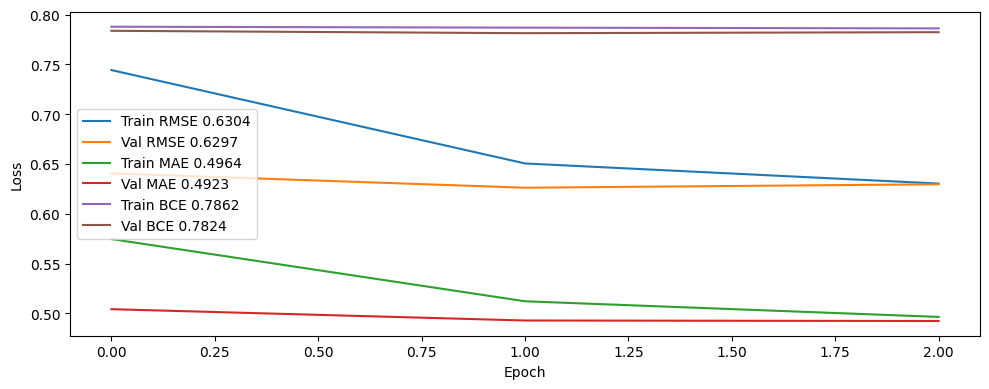

In [27]:
plt.figure(figsize=(10, 4))

plt.plot(train_reg_rmse, label=f"Train RMSE {train_reg_rmse[-1]:.4f}")
plt.plot(val_reg_rmse, label=f"Val RMSE {val_reg_rmse[-1]:.4f}")
plt.plot(train_reg_mae, label=f"Train MAE {train_reg_mae[-1]:.4f}")
plt.plot(val_reg_mae, label=f"Val MAE {val_reg_mae[-1]:.4f}")
plt.plot(train_class_bce, label=f"Train BCE {train_class_bce[-1]:.4f}")
plt.plot(val_class_bce, label=f"Val BCE {val_class_bce[-1]:.4f}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
def correct_reg_prediction(predictions):
    return np.clip(predictions, 0, 5)


train_reg_predictions_rounded = correct_reg_prediction(np.round(train_reg_predictions))
val_reg_predictions_rounded = correct_reg_prediction(np.round(val_reg_predictions))
train_reg_labels_rounded = correct_reg_prediction(np.round(train_reg_labels))
val_reg_labels_rounded = correct_reg_prediction(np.round(val_reg_labels))

print(
    "Train RMSE:",
    np.sqrt(
        np.mean((np.array(train_reg_labels) - np.array(train_reg_predictions)) ** 2)
    ),
)
print(
    "Val RMSE:",
    np.sqrt(np.mean((np.array(val_reg_labels) - np.array(val_reg_predictions)) ** 2)),
)
print(
    "Train MAE:",
    np.mean(np.abs(np.array(train_reg_labels) - np.array(train_reg_predictions))),
)
print(
    "Val MAE:",
    np.mean(np.abs(np.array(val_reg_labels) - np.array(val_reg_predictions))),
)
print(
    "Train R2:",
    1
    - np.sum((np.array(train_reg_labels) - np.array(train_reg_predictions)) ** 2)
    / np.sum((np.array(train_reg_labels) - np.mean(train_reg_labels)) ** 2),
)
print(
    "Val R2:",
    1
    - np.sum((np.array(val_reg_labels) - np.array(val_reg_predictions)) ** 2)
    / np.sum((np.array(val_reg_labels) - np.mean(val_reg_labels)) ** 2),
)
print("Train Pearson:", pearsonr(train_reg_labels, train_reg_predictions)[0])
print("Val Pearson:", pearsonr(val_reg_labels, val_reg_predictions)[0])
print("Train Spearman:", spearmanr(train_reg_labels, train_reg_predictions)[0])
print("Val Spearman:", spearmanr(val_reg_labels, val_reg_predictions)[0])

Train RMSE: 0.6505454526235849
Val RMSE: 0.6261799001472216
Train MAE: 0.5121437873919747
Val MAE: 0.49283980731750116
Train R2: 0.7020275379463683
Val R2: 0.7052912751055127
Train Pearson: 0.8379979259083153
Val Pearson: 0.8399099747819916
Train Spearman: 0.8259332947262807
Val Spearman: 0.8278946813884286


In [34]:
print("Train Classification Report:")
print(
    classification_report(
        train_reg_labels_rounded, train_reg_predictions_rounded, zero_division=0
    )
)

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.47      0.55    111333
         1.0       0.62      0.67      0.64    253208
         2.0       0.50      0.58      0.53    168293
         3.0       0.44      0.48      0.46     98695
         4.0       0.79      0.51      0.62     67497
         5.0       0.10      0.02      0.03       974

    accuracy                           0.57    700000
   macro avg       0.52      0.45      0.47    700000
weighted avg       0.59      0.57      0.57    700000



In [35]:
print("Val Classification Report:")
print(
    classification_report(
        val_reg_labels_rounded, val_reg_predictions_rounded, zero_division=0
    )
)

Val Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.52      0.58      1813
         1.0       0.64      0.67      0.66      3970
         2.0       0.52      0.62      0.57      2418
         3.0       0.48      0.52      0.50      1335
         4.0       0.76      0.47      0.58       789
         5.0       0.00      0.00      0.00        14

    accuracy                           0.60     10339
   macro avg       0.51      0.47      0.48     10339
weighted avg       0.61      0.60      0.59     10339



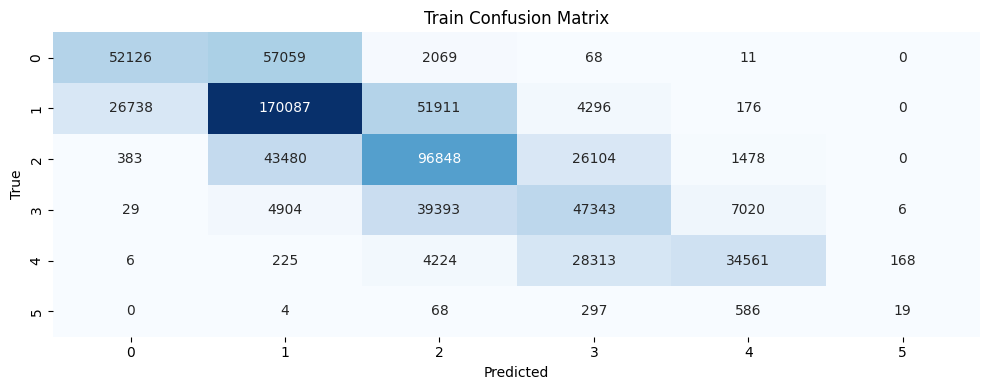

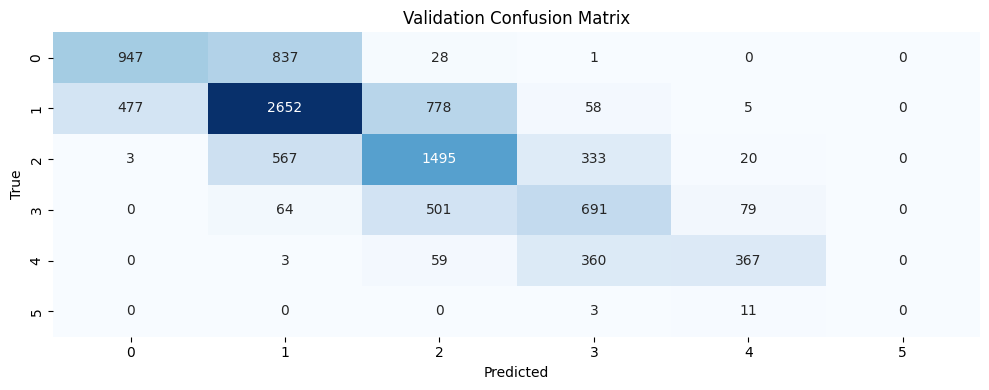

In [36]:
confusion_matrix_train = confusion_matrix(
    train_reg_labels_rounded, train_reg_predictions_rounded
)
plt.figure(figsize=(10, 4))
sns.heatmap(confusion_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

confusion_matrix_val = confusion_matrix(
    val_reg_labels_rounded, val_reg_predictions_rounded
)
plt.figure(figsize=(10, 4))
sns.heatmap(confusion_matrix_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
print("Train Classification Report:")
print(
    classification_report(
        train_class_labels, np.argmax(train_class_predictions, axis=1), zero_division=0
    )
)

Train Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      6324
           1       0.77      0.72      0.74     13277
           2       0.61      0.42      0.50      2152
           3       0.85      0.85      0.85     28356
           4       0.83      0.83      0.83     29179
           5       0.86      0.87      0.87     21212
           6       0.83      0.83      0.83     55014
           7       0.70      0.71      0.71     29497
           8       0.89      0.90      0.90     34034
           9       0.85      0.86      0.86     72456
          10       0.90      0.89      0.90     30316
          11       0.84      0.86      0.85      8862
          12       0.89      0.90      0.90     64565
          13       0.80      0.79      0.80     19268
          14       0.76      0.77      0.76     32358
          15       0.76      0.71      0.73     12483
          16       0.81      0.83      0.82     2762

In [39]:
print("Val Classification Report:")
print(classification_report(val_class_labels, np.argmax(val_class_predictions, axis=1)))

Val Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.45      0.51        66
           1       0.69      0.75      0.72       203
           2       0.63      0.52      0.57        33
           3       0.81      0.83      0.82       428
           4       0.85      0.83      0.84       390
           5       0.85      0.88      0.86       291
           6       0.82      0.82      0.82       995
           7       0.72      0.70      0.71       631
           8       0.88      0.92      0.90       542
           9       0.86      0.87      0.86       920
          10       0.91      0.94      0.93       532
          11       0.83      0.93      0.88       101
          12       0.90      0.87      0.88       621
          13       0.80      0.80      0.80       305
          14       0.76      0.71      0.74       375
          15       0.82      0.78      0.80       131
          16       0.83      0.80      0.82       608


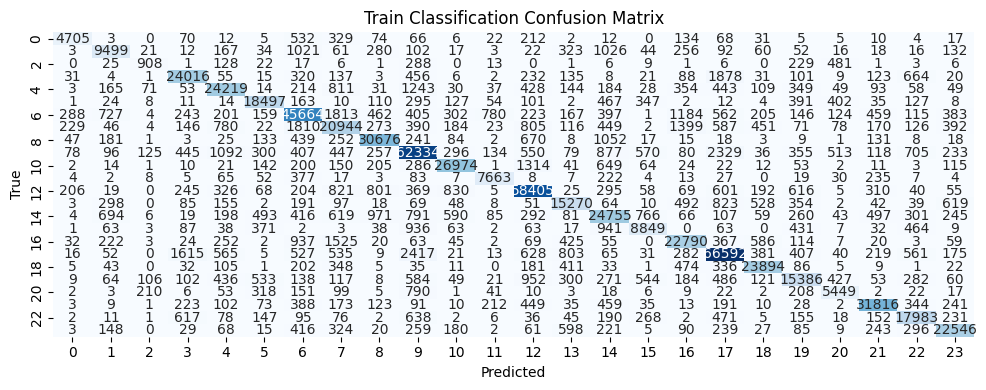

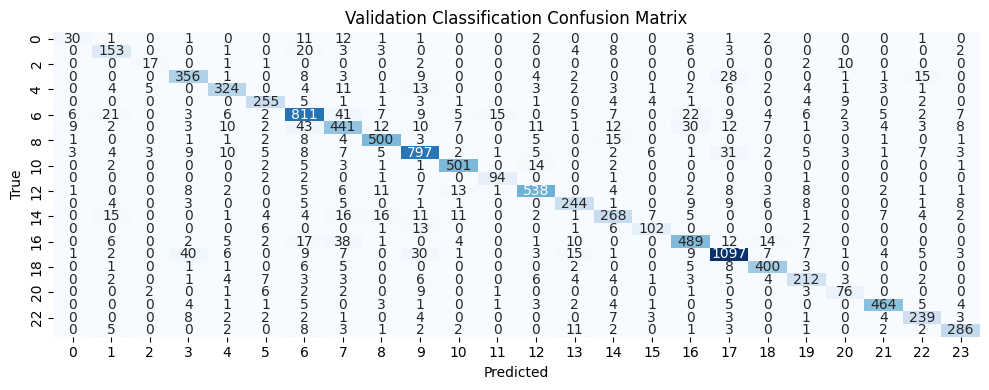

In [40]:
confusion_matrix_class_train = confusion_matrix(
    train_class_labels, np.argmax(train_class_predictions, axis=1)
)
plt.figure(figsize=(10, 4))
sns.heatmap(confusion_matrix_class_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Train Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

confusion_matrix_class_val = confusion_matrix(
    val_class_labels, np.argmax(val_class_predictions, axis=1)
)
plt.figure(figsize=(10, 4))
sns.heatmap(confusion_matrix_class_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()